In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad
from scipy.integrate import solve_ivp

# Interpolation

Purpose of interpolation

Given some $x_{\text{data}}=[...]$ and $y_{\text{data}}=[...]$ the goal is to create a function $y=f(x)$ where one can plug in any value of $x$ they want and obtain a corresponding value for $y$

**Example**

Given some data:

In [2]:
x_data = np.linspace(0,5,5)
y_data = x_data**2

Plot

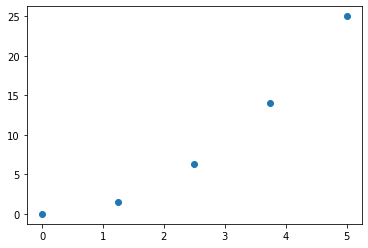

In [3]:
plt.scatter(x_data,y_data)
plt.show()

Suppose we want $f(x=1.5)$. This is not directly accessible from the data. For this we need to interpolate. 

The most basic form of interpolation is connecting lines between the points. This is what matplotlib does, as a matter of fact, when `plt.plot` is called.

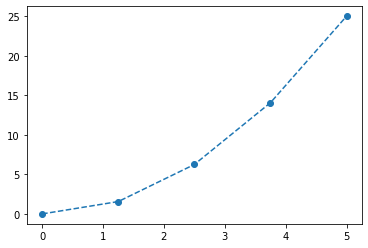

In [4]:
plt.plot(x_data,y_data,'o--')
plt.show()

This form of interpolation is **linear** interpolation. For any $x$ value, one simply moves upward from the $x$ axis to obtain the corresponding $y$ value. We can obtain a function as follows. Note that `_f` in my code represents a function

In [5]:
y_f = interp1d(x_data, y_data, 'linear')
y_f(1.5)

array(2.5)

Obtain $y$ values for many many $x$ values

In [6]:
x = np.linspace(0,5,100)
y = y_f(x)

Now plot

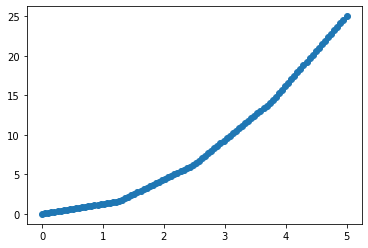

In [7]:
plt.scatter(x,y)
plt.show()

Typically it is better to use **cubic** interpolation. Rather than connecting points with straight lines, fit chunks of data to cubic polynomials and connecting these together

In [8]:
y_f = interp1d(x_data, y_data, 'cubic')

x = np.linspace(0,5,100)
y = y_f(x)

Now plot

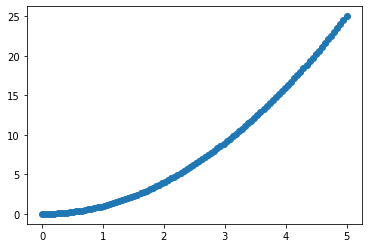

In [9]:
plt.scatter(x,y)
plt.show()

## Usefulness

So when exactly is this useful? In some situations, a functional form is preferred/required:

* computing integrals (preferred)
* differential equations (required)
* many many other applications...

**Example**: Computing integral. Given a distribution of energies in a beam of photons, compute the mean energy.

In [10]:
E_data = np.array([ 0.1  ,  0.2  ,  0.3  ,  0.4  ,  0.5  ,  0.55 ,  0.662,  0.8  ,
        1.   ,  1.25 ,  1.5  ,  2.   ,  3.   ,  4.   ,  5.   ,  6.   ,
        8.   , 10.   ])

S_data = np.array([0.   , 0.032, 0.06 , 0.086, 0.109, 0.131, 0.151, 0.185, 0.212,
       0.238, 0.257, 0.274, 0.256, 0.205, 0.147, 0.096, 0.029, 0.002])

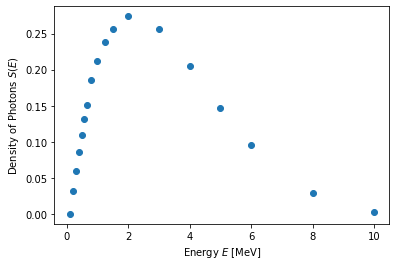

In [11]:
plt.scatter(E_data, S_data)
plt.xlabel('Energy $E$ [MeV]')
plt.ylabel('Density of Photons $S(E)$')
plt.show()

The mean energy is given by

$$\bar{E} = \frac{\int E S(E) dE}{\int S(E) dE}$$

To conveniently evaluate this integral, we need a function `S_f` that takes in an energy and returns a spectrum value

In [12]:
S_f = interp1d(E_data, S_data, 'cubic')

In [13]:
numerator = quad(lambda E: E*S_f(E), min(E_data), max(E_data))[0]
denominator = quad(lambda E: S_f(E), min(E_data), max(E_data))[0]
E_mean = numerator/denominator

In [14]:
E_mean

3.3825472782623387

**Example**: Solving a Differential Equation. The rocket equation is given by

$$ \frac{dv}{dt} = -a -\frac{b}{m(t)}v^2 - \frac{1}{m(t)}\frac{dm(t)}{dt} $$

Where $m$ is the speed at which fuel is expelled. The function $m(t)$ is needed to solve this ODE. $m(t)$ might not be known exactly, but it may be the case that it can be obtained from data

In [15]:
t_data = np.array([0.  , 0.25, 0.5 , 0.75, 1.  ])
m_data = np.array([1.        , 0.99912109, 0.971875  , 0.78642578, 0.1       ])

Fit data using interpolation

In [16]:
m_f = interp1d(t_data, m_data, 'cubic')
dmdt_f = m_f._spline.derivative(nu=1)
t = np.linspace(min(t_data),max(t_data),100)
m = m_f(t)
dmdt = dmdt_f(t)

Look at data and fit

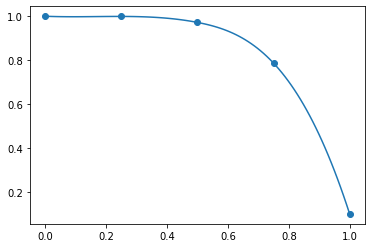

In [17]:
plt.scatter(t_data, m_data)
plt.plot(t, m)

Can look at the derivative of the cubic interpolation too

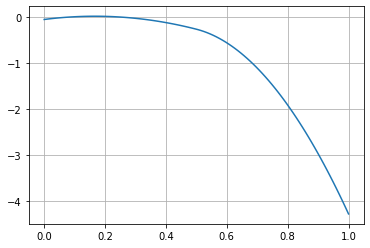

In [18]:
plt.plot(t, dmdt)
plt.grid()

We can then use the functions `m_f` and `dmdt_f` in the ode solver to solve the differential equation

In [19]:
a = 0.78
b = 0.1

def dvdt(t,v):
    return -a-b/m_f(t)-dmdt_f(t)/m_f(t)

sol = solve_ivp(dvdt, [1e-4, 1], y0=[0], t_eval=np.linspace(1e-4,1,1000))

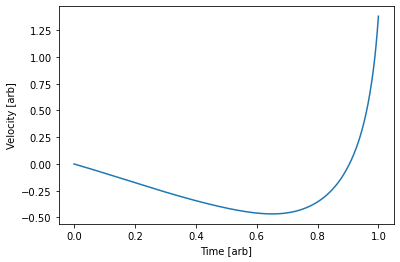

In [20]:
plt.plot(sol.t, sol.y[0])
plt.ylabel('Velocity [arb]')
plt.xlabel('Time [arb]')
plt.show()

One can also use `interp2d` for 2 dimensional interpolation. It is basically the same as in the 1 dimensional case: the documentation describes it fairly well:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d

In [21]:
x = np.array([0.  , 0.25, 0.5 , 0.75, 1.  , 0.  , 0.25, 0.5 , 0.75, 1.  , 0.  ,
       0.25, 0.5 , 0.75, 1.  , 0.  , 0.25, 0.5 , 0.75, 1.  , 0.  , 0.25,
       0.5 , 0.75, 1.  ])
y = np.array([0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.75, 0.75, 0.75, 0.75, 0.75, 1.  , 1.  ,
       1.  , 1.  , 1.  ])
z = np.array([0.    , 0.0625, 0.25  , 0.5625, 1.    , 0.0625, 0.125 , 0.3125,
       0.625 , 1.0625, 0.25  , 0.3125, 0.5   , 0.8125, 1.25  , 0.5625,
       0.625 , 0.8125, 1.125 , 1.5625, 1.    , 1.0625, 1.25  , 1.5625,
       2.    ])

In [22]:
z_f = interp2d(x,y,z,'cubic')
z_f(0.2,0.45456456)

array([0.24662894])